In [1]:
import matplotlib.pyplot as plt
import xarray as xr

from src import data_catalog
from src import tseries_mod
from src import esmlab_wrap
from src.utils import repl_coord, smooth, da_normalize, da_w_lags, regression_slope
from src.utils_plot import plot_1var

In [2]:
data_catalog.set_catalog('experiments')

active catalog: experiments


In [3]:
varnames = {'atm': ['TS', 'SFCO2_OCN'],
            'ocn': ['FG_CO2', 'IRON_FLUX', 'POC_FLUX_100m', 'photoC_diat_zint_100m', 'photoC_sp_zint_100m', 'photoC_diaz_zint_100m'],
           }

ds_dict = {}
for component in varnames:
    ds_dict[component] = {}

for experiment in ['piControl', 'esm-piControl']:
    for component in varnames:
        ds_dict[component][experiment] = tseries_mod.tseries_get_vars(varnames[component], component, experiment)

for experiment in ['piControl-cmip5', 'esm-piControl-cmip5']:
    for component in varnames:
        if component == 'atm':
            ds_dict[component][experiment] = tseries_mod.tseries_get_vars(varnames[component], component, experiment, stream='cam2.h0')
        else:
            ds_dict[component][experiment] = tseries_mod.tseries_get_vars(varnames[component], component, experiment)

# add photoC_TOT_zint_100m to ocn Datasets
for experiment, ds in ds_dict['ocn'].items():
    ds['photoC_TOT_zint_100m'] = ds['photoC_diat_zint_100m'] + ds['photoC_sp_zint_100m'] + ds['photoC_diaz_zint_100m']

legend_dict = {'piControl': 'piControl, CESM2',
               'esm-piControl': 'esm-piControl, CESM2',
               'piControl-cmip5': 'piControl, CESM1(BGC)',
               'esm-piControl-cmip5': 'esm-piControl, CESM1(BGC)',
              }


In [4]:
def corr_anal(varname_pair, expr_list, component_pair=('atm', 'atm'), region_x='Global', region_y_list=['Global']):
    lag_values = range(-30,30+1)
    max_pos_lag = max([0, max(lag_values)])
    min_neg_lag = min([0, min(lag_values)])
    varname_x, varname_y = varname_pair
    component_x, component_y = component_pair
    for region_y in region_y_list:
        print(f'varname_x={varname_x}, region_x={region_x}, varname_y={varname_y}, region_y={region_y}')
        plot_dict = {}
        for experiment in expr_list:
            # construct da_x
            tb_name = ds_dict[component_x][experiment]['time'].attrs['bounds']
            ds_x = esmlab_wrap.compute_mon_anomaly(ds_dict[component_x][experiment][[tb_name, varname_x]])
            iseldict = {}
            if 'lev' in ds_x[varname_x].dims:
                iseldict['lev'] = -1
            da_x = ds_x[varname_x].sel(region=region_x).isel(iseldict)

            # construct da_y
            # replace time with ds_x's time, so that vars are aligned in corr computation
            tb_name = ds_dict[component_y][experiment]['time'].attrs['bounds']
            ds_tmp = repl_coord('time', ds_x, ds_dict[component_y][experiment][[tb_name, varname_y]])
            ds_y = esmlab_wrap.compute_mon_anomaly(ds_tmp)
            ds_y = repl_coord('time', ds_x, ds_y)
            iseldict = {}
            if 'lev' in ds_y[varname_y].dims:
                iseldict['lev'] = -1
            da_y = ds_y[varname_y].sel(region=region_y).isel(iseldict)
            
            # apply smoothing to da_x and da_y
            smooth_edge_len = 0
            if True:
                for da in [da_x, da_y]:
                    da_sm, smooth_edge_len = smooth(da, filter_len=10*12, ret_edge_len=True)
                    da -= da_sm

            # compute lagged correlation between varname_x and varname_y
            da_x_norm = da_normalize(da_x)
            da_y_norm = da_normalize(da_y)
            da_xy_corr = (da_x_norm * da_w_lags(da_y_norm, lag_values=lag_values)).mean('time')
            da_xy_corr.attrs['long_name'] = f'lagged correlation between {varname_x} and {varname_y}'

            # compute lagged regression coefficient between varname_x and varname_y
            da_y_w_lags = da_w_lags(da_y, lag_values=lag_values)
            da_slope = regression_slope(
                da_x.isel(time=slice(smooth_edge_len-min_neg_lag, -smooth_edge_len-max_pos_lag)),
                da_y_w_lags.isel(time=slice(smooth_edge_len-min_neg_lag, -smooth_edge_len-max_pos_lag))
            )
            
            plot_dict[experiment] = xr.Dataset({'xy_corr': da_xy_corr, 'slope': da_slope})

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
        plot_1var('xy_corr', [plot_dict[expr] for expr in expr_list],
                  [legend_dict[expr] for expr in expr_list], ax=ax[0])
        ax[0].grid(True)
        ax[0].set_ylim((-1.0, 1.0))
        plot_1var('slope', [plot_dict[expr] for expr in expr_list],
                  [legend_dict[expr] for expr in expr_list], ax=ax[1])
        ax[1].grid(True)
        plt.show()


varname_x=TS, region_x=nino34, varname_y=SFCO2_OCN, region_y=Global


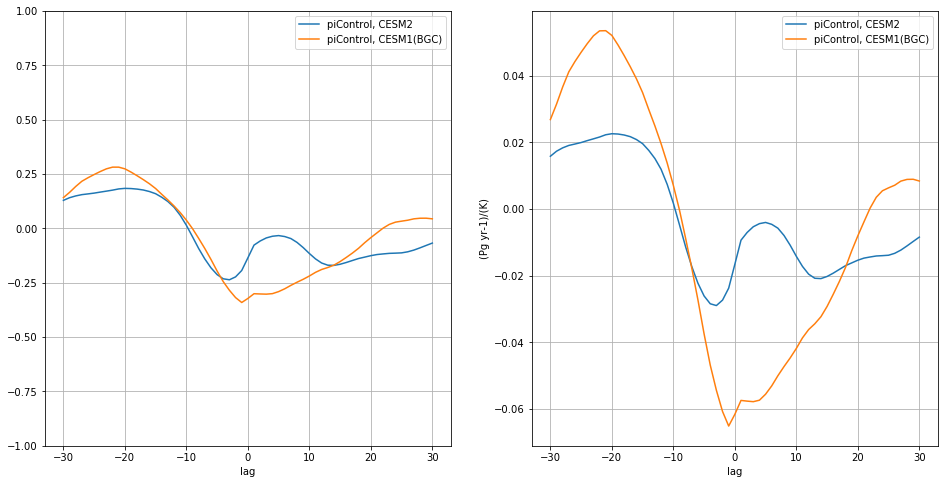

In [5]:
corr_anal(('TS', 'SFCO2_OCN'), ['piControl', 'piControl-cmip5'], region_x='nino34')

varname_x=TS, region_x=nino34, varname_y=SFCO2_OCN, region_y=Global


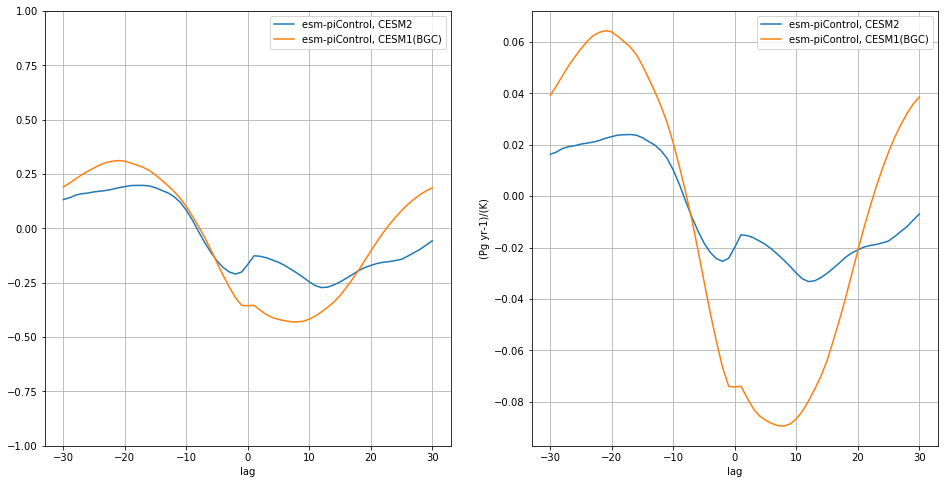

In [6]:
corr_anal(('TS', 'SFCO2_OCN'), ['esm-piControl', 'esm-piControl-cmip5'], region_x='nino34')

varname_x=TS, region_x=nino34, varname_y=SFCO2_OCN, region_y=Global


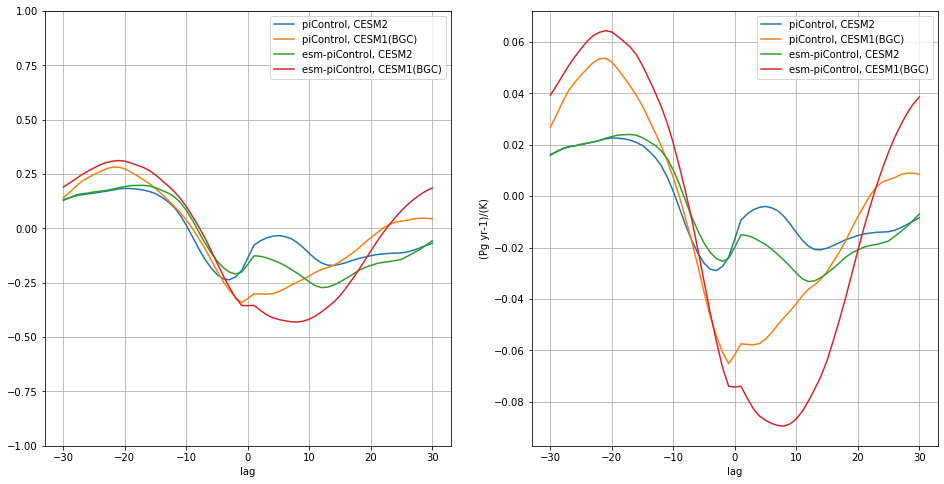

In [7]:
corr_anal(('TS', 'SFCO2_OCN'), ['piControl', 'piControl-cmip5', 'esm-piControl', 'esm-piControl-cmip5'], region_x='nino34')

varname_x=TS, region_x=nino34, varname_y=FG_CO2, region_y=Global


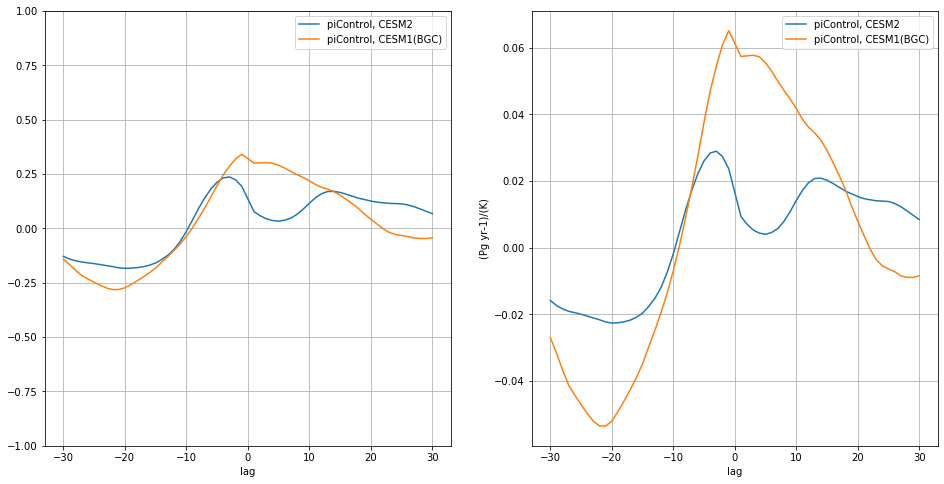

varname_x=TS, region_x=nino34, varname_y=FG_CO2, region_y=low_lat (18S-18N)


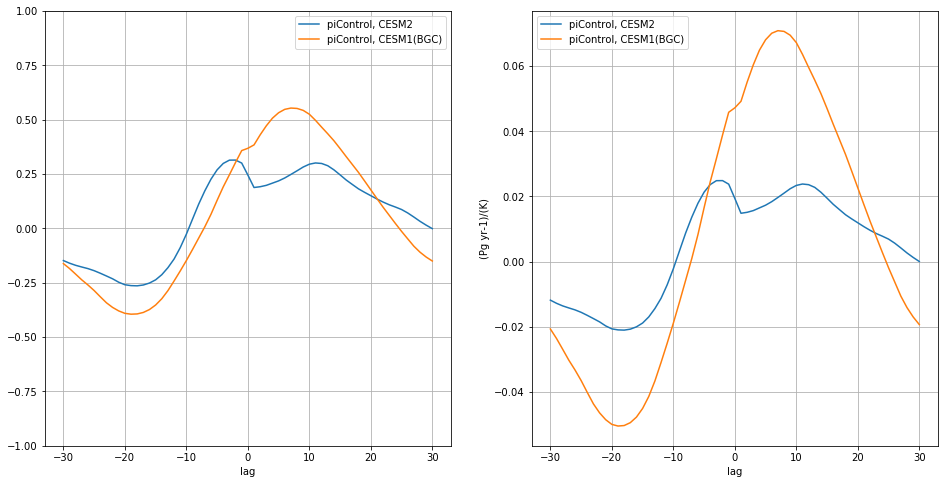

In [8]:
corr_anal(('TS', 'FG_CO2'), ['piControl', 'piControl-cmip5'], component_pair=('atm', 'ocn'), region_x='nino34',
          region_y_list=['Global', 'low_lat (18S-18N)'])

varname_x=TS, region_x=nino34, varname_y=IRON_FLUX, region_y=Global


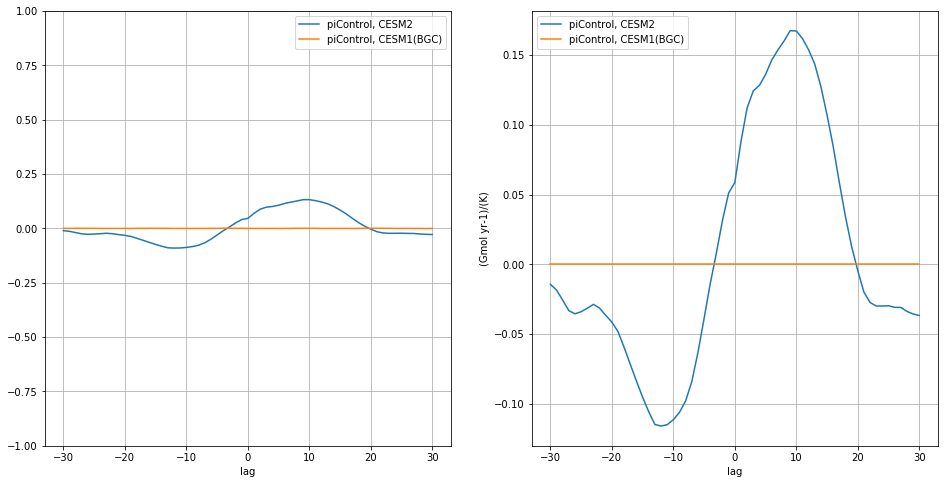

varname_x=TS, region_x=nino34, varname_y=IRON_FLUX, region_y=low_lat (18S-18N)


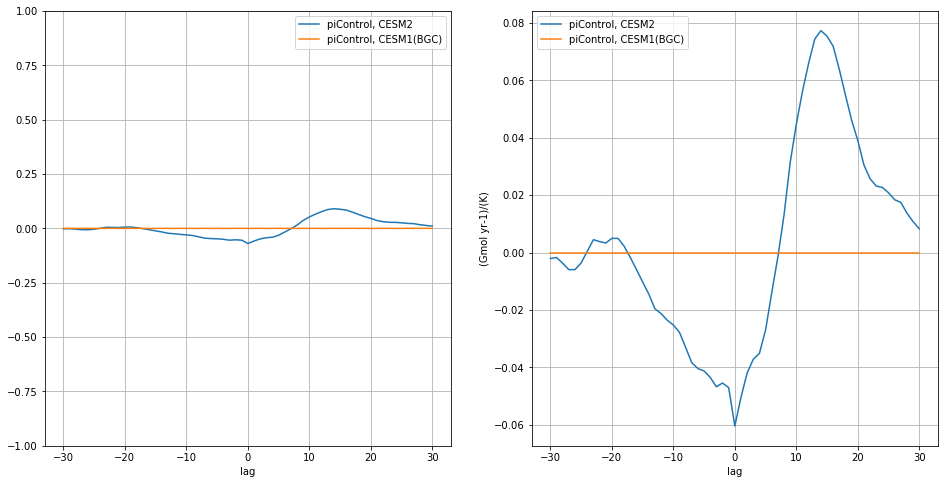

In [9]:
corr_anal(('TS', 'IRON_FLUX'), ['piControl', 'piControl-cmip5'], component_pair=('atm', 'ocn'), region_x='nino34',
          region_y_list=['Global', 'low_lat (18S-18N)'])

varname_x=TS, region_x=nino34, varname_y=POC_FLUX_100m, region_y=Global


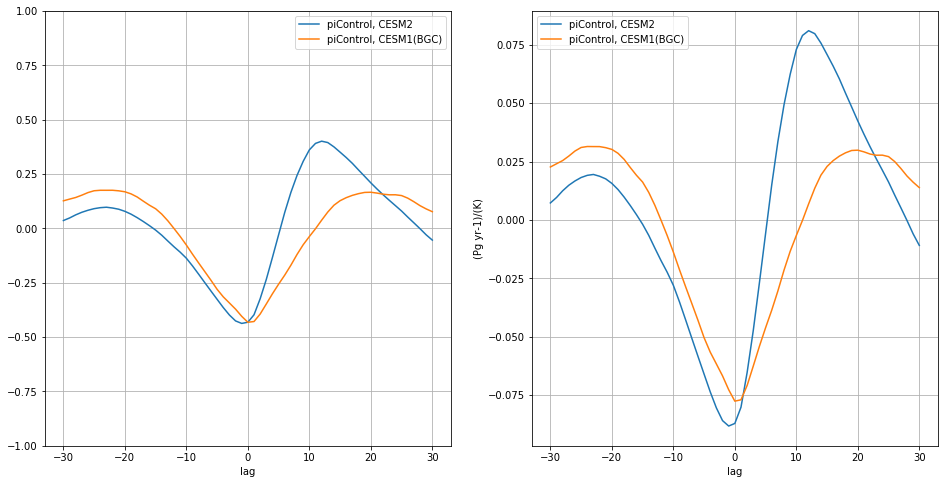

varname_x=TS, region_x=nino34, varname_y=POC_FLUX_100m, region_y=low_lat (18S-18N)


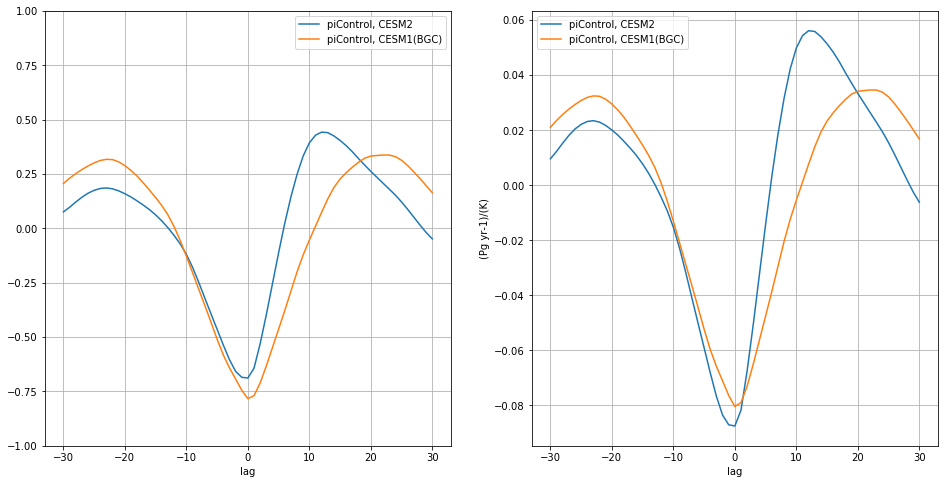

In [10]:
corr_anal(('TS', 'POC_FLUX_100m'), ['piControl', 'piControl-cmip5'], component_pair=('atm', 'ocn'), region_x='nino34',
          region_y_list=['Global', 'low_lat (18S-18N)'])

varname_x=TS, region_x=nino34, varname_y=photoC_TOT_zint_100m, region_y=Global


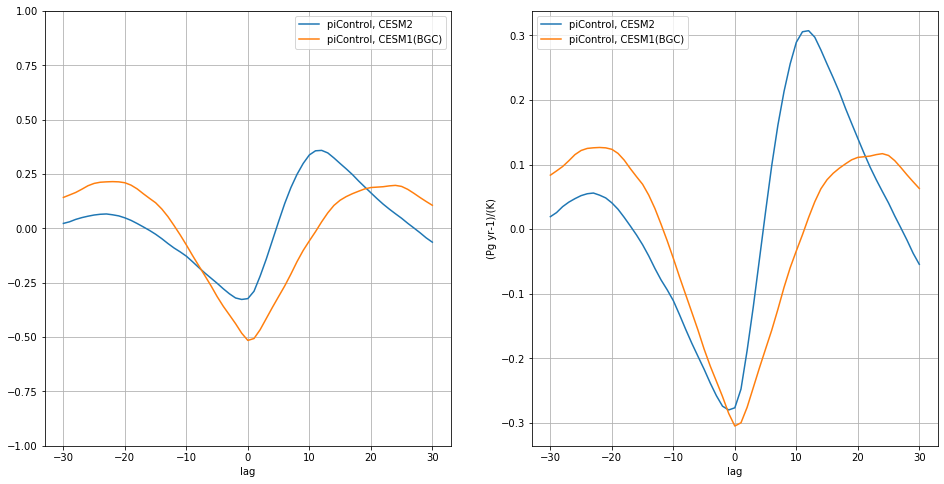

varname_x=TS, region_x=nino34, varname_y=photoC_TOT_zint_100m, region_y=low_lat (18S-18N)


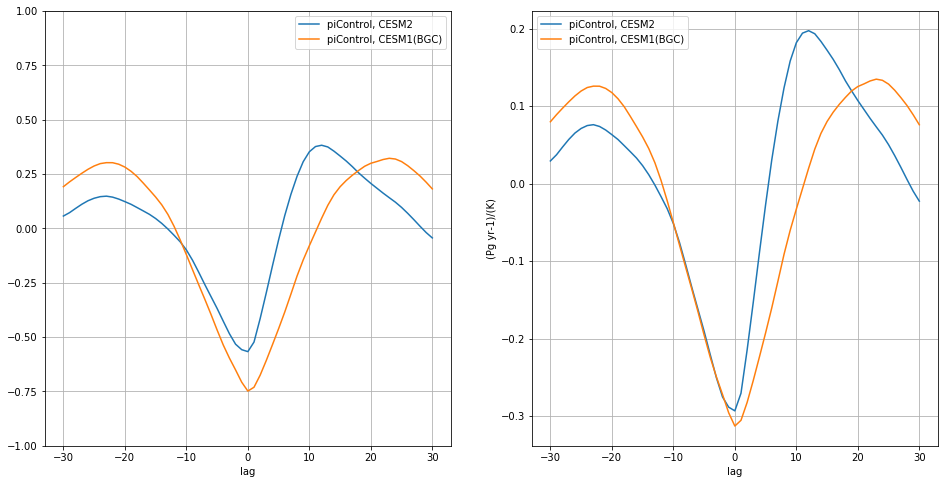

In [11]:
corr_anal(('TS', 'photoC_TOT_zint_100m'), ['piControl', 'piControl-cmip5'], component_pair=('atm', 'ocn'), region_x='nino34',
          region_y_list=['Global', 'low_lat (18S-18N)'])

varname_x=TS, region_x=nino34, varname_y=photoC_diat_zint_100m, region_y=Global


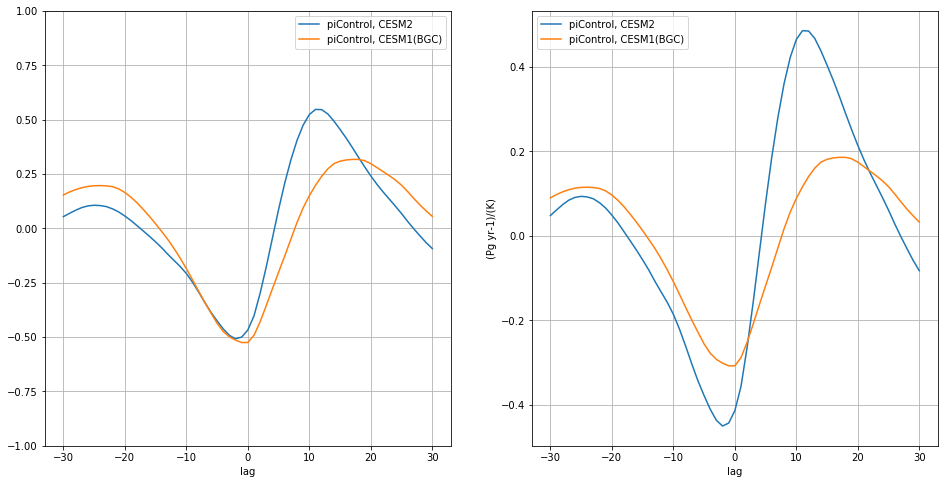

varname_x=TS, region_x=nino34, varname_y=photoC_diat_zint_100m, region_y=low_lat (18S-18N)


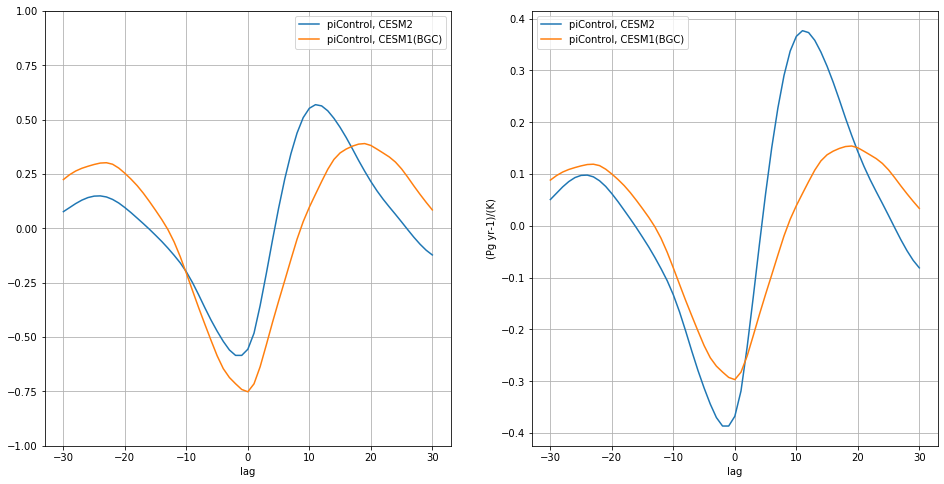

In [12]:
corr_anal(('TS', 'photoC_diat_zint_100m'), ['piControl', 'piControl-cmip5'], component_pair=('atm', 'ocn'), region_x='nino34',
          region_y_list=['Global', 'low_lat (18S-18N)'])

varname_x=TS, region_x=nino34, varname_y=photoC_sp_zint_100m, region_y=Global


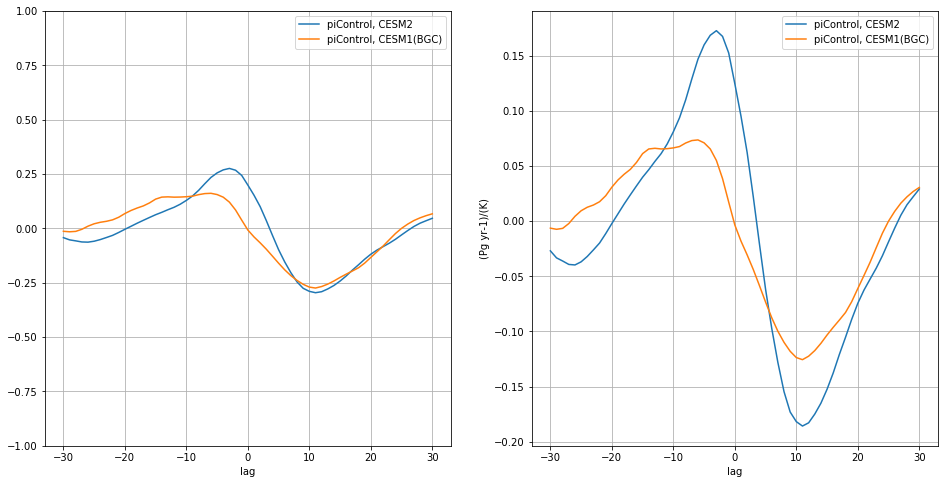

varname_x=TS, region_x=nino34, varname_y=photoC_sp_zint_100m, region_y=low_lat (18S-18N)


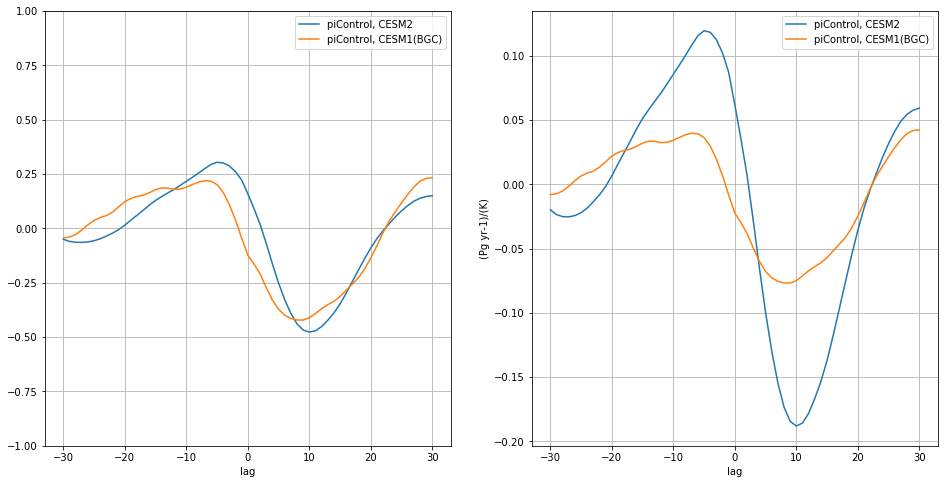

In [13]:
corr_anal(('TS', 'photoC_sp_zint_100m'), ['piControl', 'piControl-cmip5'], component_pair=('atm', 'ocn'), region_x='nino34',
          region_y_list=['Global', 'low_lat (18S-18N)'])